<a href="https://colab.research.google.com/github/pachterlab/GVFP_2021/blob/dev/figure_3E_notebook_colab_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Interpretable and tractable models of transcriptional noise for the rational design of single-molecule quantification experiments"
## by Gennady Gorin<sup>*</sup>, John Vastola<sup>*</sup>, Meichen Fang, and Lior Pachter
### <sup>*</sup> These authors contributed equally to this work.
# Companion notebook for Figure 3 

This notebook is self-contained, and generates the panels used in Figure 3 (albeit mostly without axis labels). There are five panels:

**a**. Log Bayes factors across space of qualitative regimes

**b**. Slice of a. to show distinguishability as a function of the gain ratio

**c**. Distinguishability of two models versus trivial models as function of gain ratio

**d**. Example parameter set for which $\Gamma$-OU and CIR are very different

**e**. Bayesian parameter inference

The sections of this notebook, apart from the first (which contains relevant functions), correspond to the above panels.

In [1]:
!pip install loompy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 10.3 MB/s 
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=9fd62a4a530f0627d8d1a52ec016c19cbd4cb9c3d96175ab646c3c52e7f7ce1d
  Stored in directory: /root/.cache/pip/wheels/48/36/9f/eb3377d4a7423b96105b6667d36c3faa49ee73b96d8cab80b3
Successfully built loompy


In [2]:
!git clone --branch dev https://github.com/pachterlab/GVFP_2021.git

Cloning into 'GVFP_2021'...
remote: Enumerating objects: 846, done.
remote: Counting objects: 100% (846/846), done.
remote: Compressing objects: 100% (518/518), done.
remote: Total 846 (delta 321), reused 842 (delta 320), pack-reused 0
Receiving objects: 100% (846/846), 726.98 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (321/321), done.
Checking out files: 100% (231/231), done.


In [3]:
!mv GVFP_2021/* .

In [22]:
import time as ti
import loompy as lp
import pandas as pd

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
%cd loom

/content/loom


In [8]:
!cat allen_C01_glu.tar.gz.001 allen_C01_glu.tar.gz.002 | tar -xzv
!cat allen_B08_glu.tar.gz.001 allen_B08_glu.tar.gz.002 | tar -xzv
!cat allen_H12_glu.tar.gz.001 allen_H12_glu.tar.gz.002 | tar -xzv
!cat allen_F08_glu.tar.gz.001 allen_F08_glu.tar.gz.002 | tar -xzv

allen_C01_glu.loom
allen_B08_glu.loom
allen_H12_glu.loom
allen_F08_glu.loom


## Functions

In [52]:
# -*- coding: utf-8 -*-

import pickle
from multiprocessing import Pool
# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde
import matplotlib.pyplot as plt

import scipy 
from scipy import integrate

# PyMC3-related imports
import pymc3 as pm
import theano.tensor as tt

# Plotting
import matplotlib.pyplot as plt
import arviz as az
import matplotlib as mpl

def convert_xy_to_params(x, y, beta, gamma, K_avg):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a, kappa, theta


# Sample from flattened 2D probability distribution p. 
# mx = [mx0, mx1] is the shape of the 2D domain we're sampling.
def sample_from_p(mx, num_data_points, p_flat):
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M


# Get maximum of a 2D array
def get_2D_max(array):
    return np.unravel_index(array.argmax(), array.shape)


# Get KDE for smooth-looking heatmaps.
def get_2D_KDE(x_stats, y_stats, x_min=0, x_max=1, y_min=0, y_max=1):
    num_pts = 100                          # hyperparameter
    x_arg = np.linspace(x_min, x_max, num_pts)
    y_arg = np.linspace(y_min, y_max, num_pts)

    X_arg, Y_arg = np.meshgrid(x_arg, y_arg, indexing='ij')      # grid of points      X0, X1

 
    positions = np.vstack([X_arg.ravel(), Y_arg.ravel()])
    kernel = gaussian_kde([x_stats, y_stats])
    KDE = np.reshape(kernel(positions).T, X_arg.shape)
    return KDE, x_arg, y_arg

"""### Trivial model (constitutive/Poisson and mixture/NB) likelihood functions"""

# Constitutive model likelihood function.
def get_Poiss_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    K_avg = (a*theta)/kappa
    mu_N, mu_M = K_avg/beta, K_avg/gamma
    
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')
    
    return poisson.pmf(X_N, mu_N)*poisson.pmf(X_M, mu_M)


# Mixture model likelihood function.
def get_NB_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = np.exp(- (a/kappa)*np.log(1 - theta*(g[0]/beta + g[1]/gamma)))
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

def ll_NB(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_NB_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

"""### $\Gamma$-OU likelihood functions"""

# Get 2 species GOU generating function using ODE method
def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of GOU model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_GOU(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_GOU_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result


# Combines the above functions into one to reduce overhead associated with Python function calls.
# Helpful when doing expensive posterior sampling (since many likelihood function calls are required).
def ll_GOU2(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    beta_0 = beta
    beta_1 = gamma
    
    c0 = (g[0]) + (beta_0/(beta_1 - beta_0))*(g[1])       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g[1])   
    
    # min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    # dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = (1/np.asarray(params)).max()*5
    # t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    # num_tsteps = int(np.ceil(t_max/dt))
    
    # t_array = np.linspace(0, t_max, num_tsteps+1)
    # t_array = t_array.reshape((1, num_tsteps + 1))
    
    # q = np.zeros((c0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    # c0 = c0.reshape((c0.shape[0],1))
    # c1 = c1.reshape((c1.shape[0],1))
    # q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    # q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    # q = q0 + q1
    c0 = c0[:,None]
    c1 = c1[:,None]
    def intfun_(t):
        
        q = theta*c0*(np.exp(-beta_0*t) - np.exp(-kappa*t))/(kappa - beta_0) \
          + theta*c1*(np.exp(-beta_1*t) - np.exp(-kappa*t))/(kappa - beta_1)
        return (1/(1-q) - 1)

    # integrand = q/(1-q)
    # integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    integral = scipy.integrate.fixed_quad(intfun_,0,t_max,n=60)[0]
    # integral = scipy.integrate.quad_vec(intfun_,0,t_max)[0]
    gf = np.exp( a*integral)               # get generating function
    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

"""### CIR likelihood functions"""

# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    c0 = c0[:,None]
    c1 = c1[:,None]
    # min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    # dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    # t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    t_max = (1/np.asarray(params)).max()*5
    # num_tsteps = int(np.ceil(t_max/dt))

    def intfun_(t,y):
        return f_2sp(y, t, c0, c1, params)
    rk = scipy.integrate.RK45(intfun_,0,np.zeros((g0.shape[0]), dtype=np.complex64),t_max,vectorized=True)
    while rk.t<t_max:
        rk.step()
    integral = rk.y
    # q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    # # Solve ODE using RK4 method 
    # for i in range(0, num_tsteps):
    #     t = i*dt
    #     q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0, c1, dt, params)
        
    # integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of CIR model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_CIR(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_CIR_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

"""### Bayes factor functions"""

# Generates synthetic data (either CIR or GOU) and computes log Bayes factor (e.g. P(CIR)/P(GOU))).
# Does this averaged over many trials (num_trials).
# Does this assuming different numbers of data points (e.g. num_data_points = [100, 200, 1000]). 
def log_bayes_factor_avg(model, num_data_points, num_trials, mx, params):
    
    # Initialize log BF arrays 
    num_kinds = len(num_data_points) 
    log_bf_joint = np.zeros((num_kinds, num_trials))
    log_bf_nascent = np.zeros((num_kinds, num_trials))
    log_bf_mature = np.zeros((num_kinds, num_trials))
    
    
    # Get Pss for each model given this parameter set
    if model=='CIR':
        pss = get_CIR_2sp(mx, params)
        pss_other = get_GOU_2sp(mx, params)
    elif model=='GOU':
        pss = get_GOU_2sp(mx, params)
        pss_other = get_CIR_2sp(mx, params)
    p_flat = pss.flatten()
    
    
    # Get fake data
    for r in range(0, num_kinds):
        for t in range(0, num_trials):
            
            # Sample nascent and mature counts
            d_N, d_M = sample_from_p(mx, num_data_points[r], p_flat)

            # Log-likelihood functions
            lp = np.log10(pss)    # shape: x_N_domain by x_M_domain
            lp_nascent = np.log10(np.sum(pss, axis=1))
            lp_mature = np.log10(np.sum(pss, axis=0))

            lp_other = np.log10(pss_other)
            lp_other_nascent = np.log10(np.sum(pss_other, axis=1))
            lp_other_mature = np.log10(np.sum(pss_other, axis=0))

            # Log-likelihoods given data
            ll_joint = np.sum(lp[d_N, d_M])
            ll_nascent = np.sum(lp_nascent[d_N])
            ll_mature = np.sum(lp_mature[d_M])

            ll_other_joint = np.sum(lp_other[d_N, d_M])
            ll_other_nascent = np.sum(lp_other_nascent[d_N]) 
            ll_other_mature = np.sum(lp_other_mature[d_M])

            # Bayes factor
            log_bf_joint[r,t] = ll_joint - ll_other_joint
            log_bf_nascent[r,t] = ll_nascent - ll_other_nascent
            log_bf_mature[r,t] = ll_mature - ll_other_mature
                          
        log_bf_joint_avg = np.mean(log_bf_joint, axis=1)
        log_bf_nascent_avg = np.mean(log_bf_nascent, axis=1)
        log_bf_mature_avg = np.mean(log_bf_mature, axis=1)
    
    return log_bf_joint_avg, log_bf_nascent_avg, log_bf_mature_avg

# Compute averaged log Bayes factors for GOU vs Poisson, GOU vs NB, CIR vs Poisson, and CIR vs NB.
def log_bayes_factor_avg_null(num_data_points, num_trials, mx, params):
    
    # Get Pss for each model given this parameter set
    pss_CIR = get_CIR_2sp(mx, params)
    pss_GOU = get_GOU_2sp(mx, params)
    pss_Poiss = get_Poiss_2sp(mx, params)
    pss_NB = get_NB_2sp(mx, params)
    
    # Initialize log BF arrays
    log_bf_CIR_vs_Poiss, log_bf_CIR_vs_NB = np.zeros(num_trials), np.zeros(num_trials)
    log_bf_GOU_vs_Poiss, log_bf_GOU_vs_NB = np.zeros(num_trials), np.zeros(num_trials)
    
    for t in range(0, num_trials):
        
        # Get fake data
        d_GOU_N, d_GOU_M = sample_from_p(mx, num_data_points, pss_GOU.flatten())
        d_CIR_N, d_CIR_M = sample_from_p(mx, num_data_points, pss_CIR.flatten())


        # Log-likelihood functions
        lp_CIR = np.log10(pss_CIR)    # shape: mx[0] by mx[1]
        lp_GOU = np.log10(pss_GOU)  
        lp_Poiss = np.log10(pss_Poiss) 
        lp_NB = np.log10(pss_NB) 


        # Log-likelihoods given data
        log_bf_CIR_vs_Poiss[t] = np.sum(lp_CIR[d_CIR_N, d_CIR_M]) - np.sum(lp_Poiss[d_CIR_N, d_CIR_M]) 
        log_bf_CIR_vs_NB[t] = np.sum(lp_CIR[d_CIR_N, d_CIR_M]) - np.sum(lp_NB[d_CIR_N, d_CIR_M]) 

        log_bf_GOU_vs_Poiss[t] = np.sum(lp_GOU[d_GOU_N, d_GOU_M]) - np.sum(lp_Poiss[d_GOU_N, d_GOU_M]) 
        log_bf_GOU_vs_NB[t] = np.sum(lp_GOU[d_GOU_N, d_GOU_M]) - np.sum(lp_NB[d_GOU_N, d_GOU_M]) 
        
    log_bf_CIR_vs_Poiss_avg = np.mean(log_bf_CIR_vs_Poiss)
    log_bf_CIR_vs_NB_avg = np.mean(log_bf_CIR_vs_NB)
    log_bf_GOU_vs_Poiss_avg = np.mean(log_bf_GOU_vs_Poiss)
    log_bf_GOU_vs_NB_avg = np.mean(log_bf_GOU_vs_NB)

    
    return log_bf_CIR_vs_Poiss_avg, log_bf_CIR_vs_NB_avg, log_bf_GOU_vs_Poiss_avg, log_bf_GOU_vs_NB_avg

"""### Bayesian parameter recovery functions"""

# This class is necessary for interfacing with PymC3.

class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, const, mx, data, likelihood):
        
        # add inputs as class attributes
        self.const = const
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.const, self.mx, self.data) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood

# This function gets parameter posteriors via non-gradient-based sampling.
def get_parameter_posteriors(string_ID, const, mx, data, ll_func, draws_=2000, tune_=1000, chains_=None, cores_=None):
    
    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    
    # Define log likelihood
    logl_op = LogLike(const, mx, data, ll_func)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        # Priors
        x_ = pm.Uniform('x', lower=x_min, upper=x_max)
        y_ = pm.Uniform('y', lower=y_min, upper=y_max)

        phi = tt.as_tensor_variable([x_, y_])

        # Likelihood
        pm.Potential('likelihood', logl_fun(phi))
        
        
    # Run PyMC3 model
    start_time = ti.time()
    with model:
        step = pm.DEMetropolisZ(tune = None)
        trace = pm.sample(draws = draws_, tune = tune_, step = step, chains = chains_, cores = cores_ )
    print("--- %s seconds ---" % (ti.time() - start_time))
        
    # Plot and save trace
    with model:
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig("results/pymc3_raw_"+string_ID+".png", bbox_inches='tight')
        fig.savefig("results/pymc3_raw_"+string_ID+".pdf", bbox_inches='tight')
        
    x_stats, y_stats = trace['x'], trace['y']
    return trace, x_stats, y_stats

# This function analyzes and plots the posterior samples.
def analyze_posteriors(string_ID, x_stats, y_stats, params_true, sim=True, loc=True, k_max=1, th_max=1):
    
    if sim:
        # True parameters
        beta, gamma, a_true, kappa_true, theta_true = params_true
        x_true, y_true = (kappa_true)/(kappa_true + beta + gamma), (theta_true)/(theta_true + a_true)
    else:
        # Get statistics in terms of kappa and theta
        beta, gamma, K_avg = params_true
        a_stats, kappa_stats, theta_stats = convert_xy_to_params(x_stats, y_stats, beta, gamma, K_avg)

    
    # KDEs
    KDE_xy, x_arg, y_arg = get_2D_KDE(x_stats, y_stats, 0, 1, 0, 1)
    if k_max==0:
        k_max = np.max(kappa_stats)
    if th_max==0:
        th_max = np.max(theta_stats)
    KDE_kth, k_arg, th_arg = get_2D_KDE(kappa_stats, theta_stats, 0, k_max, 0, th_max)
    
    KDE_x = np.sum(KDE_xy, axis=1)
    KDE_x = KDE_x/np.trapz(KDE_x, x=x_arg)
    KDE_y = np.sum(KDE_xy, axis=0)
    KDE_y = KDE_y/np.trapz(KDE_y, x=y_arg)
    
    KDE_k = np.sum(KDE_kth, axis=1)
    KDE_k = KDE_k/np.trapz(KDE_k, x=k_arg)
    KDE_th = np.sum(KDE_kth, axis=0)
    KDE_th = KDE_th/np.trapz(KDE_th, x=th_arg)
    
    # Summary statistics
    x_avg, y_avg = np.mean(x_stats), np.mean(y_stats)    # posterior means
    i, j = get_2D_max(KDE_xy)
    x_map, y_map = x_arg[i], y_arg[j]
    
    k_avg, th_avg = np.mean(kappa_stats), np.mean(theta_stats)    # posterior means
    i, j = get_2D_max(KDE_kth)
    k_map, th_map = k_arg[i], th_arg[j]
    
    
    
    
    print("Plotting histograms in terms of (x,y)...")
    vals, _,  _ = plt.hist(x_stats, alpha=0.5, density=True)
    # plt.plot(x_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(x_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(x_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(x_arg, KDE_x, color='black')
    plt.xlabel('$\\kappa/(\\kappa + \\beta + \\gamma)$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_x_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_x_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()

    vals, _, _ = plt.hist(y_stats, alpha=0.5, density=True)
    # plt.plot(y_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(y_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(y_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(y_arg, KDE_y, color='black')
    plt.xlabel('$\\theta/(\\theta + a)$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_y_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_y_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()
    
    
    print("Plotting histograms in terms of (kappa, theta)...")
    vals, _,  _ = plt.hist(kappa_stats, alpha=0.5, density=True)
    # plt.plot(kappa_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(k_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(k_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(k_arg, KDE_k, color='black')
    plt.xlabel('$\\kappa$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_kappa_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_kappa_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()

    vals, _, _ = plt.hist(theta_stats, alpha=0.5, density=True)
    # plt.plot(theta_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(th_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(th_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(th_arg, KDE_th, color='black')
    plt.xlabel('$\\theta$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_theta_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_theta_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()
    
    s= mpl.rcParams['lines.markersize']**2
    newsize=3*s
    
    print("Plotting 2D heatmap in terms of (x, y)...")
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(x_map, y_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(x_avg, y_avg, color='red', label='avg', s=newsize, edgecolor='white')
    # ax.scatter(x_true, y_true, color='black', label='true', s=newsize, edgecolor='white')
    ax.imshow(np.transpose(KDE_xy), origin='lower', extent=[0, 1, 0, 1])

    if loc==True:
        plt.legend(fontsize=18, framealpha=1)
    plt.savefig('results/post_2D_xy_'+string_ID+'.pdf', bbox_inches='tight')
    plt.savefig('results/post_2D_xy_'+string_ID+'.png', bbox_inches='tight')

    plt.show()
    
    
    
    
        
    print("Plotting 2D heatmap in terms of (kappa, theta)...")
    w1 = 60
    w2 = 60
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(k_map, th_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(k_avg, th_avg, color='red', label='avg', s=newsize, edgecolor='white')
    # ax.scatter(kappa_true, theta_true, color='black', label='true', s=newsize, edgecolor='white')
    ax.imshow( np.transpose(KDE_kth[:w1,:w2]), origin='lower', extent=[0, k_arg[w1], 0, th_arg[w2]], aspect='auto')

    plt.savefig('results/post_2D_kth_'+string_ID+'.pdf', bbox_inches='tight')
    plt.savefig('results/post_2D_kth_'+string_ID+'.png', bbox_inches='tight')

    plt.show()

    return

"""### Real data Bayes factor functions"""
# This function gets parameter posteriors via smc.
"""### Real data Bayes factor functions"""
# This function gets parameter posteriors via smc.
def get_parameter_posteriors_smc(string_ID, const, mx, data, ll_func, draws_=1000, chains_=1, cores_=1):
    """"Arguments changed for sample_smc function. Here is pymc3 3.8"""
    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    
    # Define log likelihood
    logl_op = LogLike(const, mx, data, ll_func)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        # Priors
        x_ = pm.Uniform('x', lower=x_min, upper=x_max)
        y_ = pm.Uniform('y', lower=y_min, upper=y_max)

        phi = tt.as_tensor_variable([x_, y_])

        # Likelihood
        pm.Potential('likelihood', logl_fun(phi))
        
        
    # Run PyMC3 model
    start_time = ti.time()
    with model:
        trace = pm.sample_smc(draws = draws_, chains = chains_, cores = cores_)
    #print("--- %s seconds ---" % (ti.time() - start_time))
        
    # Plot and save trace
    #with model:
        #axes = az.plot_trace(trace)
        #fig = axes.ravel()[0].figure
        #fig.savefig("results/pymc3_trace_"+string_ID+".png", bbox_inches='tight')
        #fig.savefig("results/pymc3_trace_"+string_ID+".pdf", bbox_inches='tight')
        
    return trace
  
def get_log_bayes_factor_data(args):
    data, gene_ID = args
    d_N, d_M = data
    mx = [np.max(d_N)+10,np.max(d_M)+10]
    K_avg = 1
    beta = K_avg/d_N.mean()
    gamma = K_avg/d_M.mean()
    const = [beta, gamma, K_avg]
    trace_GOU = get_parameter_posteriors_smc(gene_ID+"_GOU", const, mx, data, ll_func=ll_GOU2, chains_=1, cores_=1)
    trace_CIR = get_parameter_posteriors_smc(gene_ID+"_CIR", const, mx, data, ll_func=ll_CIR, chains_=1, cores_=1)
    trace = {"GOU": trace_GOU, "CIR": trace_CIR}
    
    with open('smc_results/smc_'+gene_ID+'_trace.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(trace, f)

    lml_GOU = trace_GOU.report.log_marginal_likelihood
    lml_CIR = trace_CIR.report.log_marginal_likelihood
    log_BF = np.log10(np.exp(lml_GOU-lml_CIR))
    return log_BF, gene_ID



def get_log_bayes_factor_data_grid(data, string_ID, n_threads, num_x, num_y):
    d_N, d_M = data
    K_avg = 1
    beta = K_avg/d_N.mean()
    gamma = K_avg/d_M.mean()
    mx = [np.max(d_N)+10,np.max(d_M)+10]
    const = beta, gamma, K_avg

    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    x, y = np.linspace(x_min, x_max, num_x), np.linspace(y_min, y_max, num_y)

    logL_NB = np.zeros((num_x, num_y))

    params = [beta, gamma, 1, 1, 1]
    pss_Poi = get_Poiss_2sp(mx, params)
    lp_Poi = np.log(pss_Poi)  
    lml_Poi = np.sum(lp_Poi[d_N, d_M])

    Input = []
    for i in range(0, num_x):
        for j in range(0, num_y):
            phi = [x[i], y[j]]
            Input.append((phi, const, mx, data))

    with Pool(n_threads) as pool: 
         logL_CIR = pool.starmap(ll_CIR, Input, chunksize=1)
         logL_CIR = np.reshape(logL_CIR,(num_x, num_y))
         logL_GOU = pool.starmap(ll_GOU2, Input, chunksize=1)
         logL_GOU = np.reshape(logL_GOU,(num_x, num_y))
         logL_NB = pool.starmap(ll_NB, Input, chunksize=1)
         logL_NB = np.reshape(logL_NB,(num_x, num_y))
           
    c=np.max(logL_GOU)
    d=np.max(logL_CIR)
    e=np.max(logL_NB)
    
    llh_NB = np.exp(logL_NB-e)
    llh_GOU = np.exp(logL_GOU-c)
    #plt.imshow(np.transpose(llh_GOU), extent=(0,1,0,1), origin='lower');
    #plt.savefig("grid_results/grid_posterior_"+string_ID+"_GOU.png", bbox_inches='tight')
    llh_CIR = np.exp(logL_CIR-d)
    #plt.imshow(np.transpose(llh_CIR), extent=(0,1,0,1), origin='lower',);
    #plt.savefig("grid_results/grid_posterior_"+string_ID+"_CIR.png", bbox_inches='tight')
    
    np.savetxt("grid_results/logL_"+string_ID+"_CIR.txt",logL_CIR)
    np.savetxt("grid_results/logL_"+string_ID+"_GOU.txt",logL_GOU)
    
    lml_GOU = c+np.log(np.mean(llh_GOU))
    lml_CIR = d+np.log(np.mean(llh_CIR))
    lml_NB = e+np.log(np.mean(llh_NB))

    return (lml_CIR-lml_GOU)/np.log(10), lml_CIR/np.log(10), lml_GOU/np.log(10), lml_Poi/np.log(10), lml_NB/np.log(10)


## Profile Pss calculation

In [10]:
import cProfile
sample = "allen_B08_glu"
gene = 'Gria2'
with lp.connect(sample+'.loom') as ds:
        S = ds.layers['spliced'][:]
        U = ds.layers['unspliced'][:]
        gene_names = ds.ra['gene_name']
        nCells = len(ds.ca['barcode'])
        gene_ID = sample+"_"+gene 
        i = np.where(gene_names==gene)[0][0]
        d_M = S[i].astype(int)
        d_N = U[i].astype(int)
        data = [d_N, d_M]
        K_avg = 1
        beta = K_avg/d_N.mean()
        gamma = K_avg/d_M.mean()
        mx = [np.max(d_N)+10,np.max(d_M)+10]
        const = beta, gamma, K_avg

In [56]:
cProfile.run('ll_CIR([0.95,0.95], const, mx, data)')

         26845 function calls (26206 primitive calls) in 1.179 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(broadcast_arrays)
     2832    0.004    0.000    0.172    0.000 <__array_function__ internals>:2(dot)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(ifft)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(irfft)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(irfftn)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(meshgrid)
      317    0.001    0.000    0.023    0.000 <__array_function__ internals>:2(norm)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(sum)
        2    0.000    0.000    0.000    0.000

In [57]:
cProfile.run('ll_GOU2([0.95,0.95], const, mx, data)')

         141 function calls (136 primitive calls) in 0.098 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(broadcast_arrays)
        1    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(ifft)
        1    0.000    0.000    0.007    0.007 <__array_function__ internals>:2(irfft)
        1    0.000    0.000    0.008    0.008 <__array_function__ internals>:2(irfftn)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(meshgrid)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(real)
        3    0.000    0.000    0.017    0.006 <__array_function__ internals>:2(sum)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(swapaxes)
        1    0.008    0.008    0.098    0.098 <ipython-input-52-6a129c6c231e>:189(ll_GOU2)
        1    0.000    0.000    0.000 

In [26]:
!pip install line-profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.4 MB/s 


In [27]:
%load_ext line_profiler


In [55]:
%lprun -f ll_GOU2 p=ll_GOU2([0.95,0.95], const, mx, data)


In [54]:
%lprun -f get_gf_CIR_2sp p=ll_CIR([0.95,0.95], const, mx, data)


In [ ]:
sample = "allen_C01_glu"
gene = 'Cox6b1'
with lp.connect(sample+'.loom') as ds:
        S = ds.layers['spliced'][:]
        U = ds.layers['unspliced'][:]
        gene_names = ds.ra['gene_name']
        nCells = len(ds.ca['barcode'])
        gene_ID = sample+"_"+gene 
        i = np.where(gene_names==gene)[0][0]
        d_M = S[i].astype(int)
        d_N = U[i].astype(int)
        data = [d_N, d_M]
        K_avg = 1
        beta = K_avg/d_N.mean()
        gamma = K_avg/d_M.mean()
        mx = [np.max(d_N)+10,np.max(d_M)+10]
        const = beta, gamma, K_avg

In [ ]:
cProfile.run("get_log_bayes_factor_data_grid(data, gene_ID, n_threads = 2, num_x=10, num_y=10)")

         2048 function calls (2019 primitive calls) in 36.944 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amax)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_1d)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(broadcast_arrays)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(clip)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(extract)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(iscomplexobj)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(linspace)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(mean)
        1    0.000    0.000   

## Panel E: Fitting real data

In [ ]:
sample_lists = ["allen_C01_glu","allen_B08_glu","allen_H12_glu","allen_F08_glu"]
genes_list = ['Cox6b1', 'Mdh1', 'Slc24a3', 'Stmn3', 'Gria2', 'Slc35f1', 'Trhde', 'Atxn1']

### Grids approximation

#### Calculate marginal likelihood

In [ ]:
tstart = ti.time()
IDs = []
log10_BFs = []
lml_Pois = []
lml_NBs = []
lml_CIRs = []
lml_GOUs = []
threads = 40

for sample in sample_lists:
    with lp.connect(sample+'.loom') as ds:
        S = ds.layers['spliced'][:]
        U = ds.layers['unspliced'][:]
        gene_names = ds.ra['gene_name']
        nCells = len(ds.ca['barcode'])
  
    for i,gene in enumerate(genes_list):
        gene_ID = sample+"_"+gene 
        i = np.where(gene_names==gene)[0][0]
        d_M = S[i].astype(int)
        d_N = U[i].astype(int)
        data = [d_N, d_M]
        log10_BF, lml_CIR, lml_GOU, lml_Poi, lml_NB  = get_log_bayes_factor_data_grid(data, gene_ID, n_threads = threads, num_x=100, num_y=100)
        IDs.append(gene_ID)
        log10_BFs.append(log10_BF)
        lml_CIRs.append(lml_CIR)
        lml_GOUs.append(lml_GOU)
        lml_NBs.append(lml_NB)
        lml_Pois.append(lml_Poi)
        print(gene_ID, - tstart + ti.time())
        

data = pd.DataFrame({'IDs': IDs, 'log10_BF': log10_BFs,'CIR': lml_CIRs, 'GOU': lml_GOUs, 'Poi':lml_Pois, 'NB': lml_NBs})
data.to_csv("grid_results/BF_grid_100_all.csv")

allen_C01_glu_Cox6b1 103.44116044044495
allen_C01_glu_Mdh1 222.50560927391052
allen_C01_glu_Slc24a3 456.8806140422821
allen_C01_glu_Stmn3 640.4961051940918
allen_C01_glu_Gria2 1125.9857726097107
allen_C01_glu_Slc35f1 1562.721935749054
allen_C01_glu_Trhde 1927.810162782669
allen_C01_glu_Atxn1 2534.428898334503
allen_B08_glu_Cox6b1 2732.234503507614
allen_B08_glu_Mdh1 3035.8181931972504
allen_B08_glu_Slc24a3 3394.213012456894
allen_B08_glu_Stmn3 3963.039276599884
allen_B08_glu_Gria2 6278.949841976166
allen_B08_glu_Slc35f1 6984.983528137207
allen_B08_glu_Trhde 7496.142673969269
allen_B08_glu_Atxn1 8403.743491888046
allen_H12_glu_Cox6b1 8546.492923021317
allen_H12_glu_Mdh1 8712.107820272446
allen_H12_glu_Slc24a3 9081.224029064178
allen_H12_glu_Stmn3 9318.807128667831
allen_H12_glu_Gria2 9945.023600578308
allen_H12_glu_Slc35f1 10372.527148246765
allen_H12_glu_Trhde 10679.460440397263
allen_H12_glu_Atxn1 11190.252023935318
allen_F08_glu_Cox6b1 11380.200782299042
allen_F08_glu_Mdh1 11658.1792

#### Read in marginal likelihood data

In [ ]:
import pandas as pd

df1 = pd.read_csv('grid_results/BF_grid_100_1.csv')
df2 = pd.read_csv('grid_results/BF_grid_100_2.csv')
df_all = pd.read_csv('grid_results/BF_grid_100_all.csv')

df = pd.concat([df1, df2])
df

,Unnamed: 0,IDs,log10_BF,CIR,GOU,Poi,NB
0,0,allen_C01_glu_Cox6b1,9.213975,-8109.009399,-8118.223375,-8650.061534,-8116.387169
1,1,allen_C01_glu_Mdh1,12.167449,-7806.225389,-7818.392838,-8201.277127,-7820.218708
2,2,allen_C01_glu_Slc24a3,-119.606878,-8783.543586,-8663.936708,-16560.474823,-8781.329338
3,3,allen_C01_glu_Stmn3,40.565288,-10014.136335,-10054.701623,-11264.306116,-10082.019702
4,4,allen_C01_glu_Gria2,17.047982,-14283.679512,-14300.727495,-18895.026890,-14644.365301
5,5,allen_C01_glu_Slc35f1,-83.903068,-11885.242710,-11801.339642,-18556.256142,-11900.800670
6,6,allen_C01_glu_Trhde,-156.944773,-11317.961994,-11161.017222,-18120.612446,-11319.609584
7,7,allen_C01_glu_Atxn1,-77.831664,-14338.176641,-14260.344977,-20223.235872,-14534.321721
8,8,allen_B08_glu_Cox6b1,64.363498,-8838.189713,-8902.553211,-11323.356491,-8896.917968
9,9,allen_B08_glu_Mdh1,66.396747,-8879.468229,-8945.864976,-11078.404594,-8950.161055


In [ ]:
df_all

,Unnamed: 0,IDs,log10_BF,CIR,GOU,Poi,NB
0,0,allen_C01_glu_Cox6b1,9.110247,-8109.009399,-8118.119647,-8650.061534,-8116.387169
1,1,allen_C01_glu_Mdh1,11.269179,-7806.225389,-7817.494568,-8201.277127,-7820.218708
2,2,allen_C01_glu_Slc24a3,-119.614623,-8783.543586,-8663.928963,-16560.474823,-8781.329338
3,3,allen_C01_glu_Stmn3,36.507324,-10014.136335,-10050.643659,-11264.306116,-10082.019702
4,4,allen_C01_glu_Gria2,16.735857,-14283.679512,-14300.415369,-18895.026890,-14644.365301
5,5,allen_C01_glu_Slc35f1,-83.897726,-11885.242710,-11801.344985,-18556.256142,-11900.800670
6,6,allen_C01_glu_Trhde,-156.925827,-11317.961994,-11161.036167,-18120.612446,-11319.609584
7,7,allen_C01_glu_Atxn1,-77.826285,-14338.176641,-14260.350356,-20223.235872,-14534.321721
8,8,allen_B08_glu_Cox6b1,64.249880,-8838.189713,-8902.439593,-11323.356491,-8896.917968
9,9,allen_B08_glu_Mdh1,65.054738,-8879.468229,-8944.522967,-11078.404594,-8950.161055


In [ ]:
IDs = df["IDs"]
genes = [ ID[14:] for ID in IDs]
log10_BF = df["log10_BF"]
CIR = df["CIR"]
GOU = df["GOU"]
NB = df["NB"]
Poi = df["Poi"]

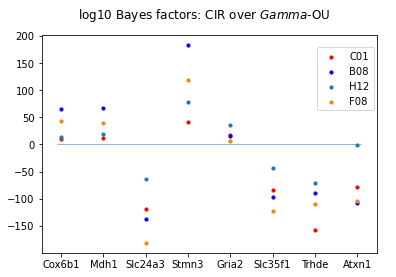

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharey=True)
axs.scatter(genes[:8], log10_BF[:8],c='r',label='C01',s=10);
axs.scatter(genes[8:16], log10_BF[8:16],c='b',label='B08',s=10);
axs.scatter(genes[16:24], log10_BF[16:24],label='H12',s=10);
axs.scatter(genes[24:32], log10_BF[24:32],label='F08',s=10);
axs.hlines(0,-0.1,7.1,linewidth=0.5)
fig.suptitle(r'log10 Bayes factors: CIR over $Gamma$-OU')
fig.legend(loc=(0.8,0.6));

In [ ]:
np.min(np.abs(log10_BF))

1.3539088694014936

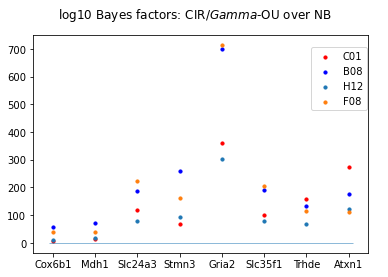

In [ ]:
import matplotlib.pyplot as plt

log10_BF = np.maximum(CIR,GOU)-NB
fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharey=True)
axs.scatter(genes[:8], log10_BF[:8],c='r',label='C01',s=10);
axs.scatter(genes[8:16], log10_BF[8:16],c='b',label='B08',s=10);
axs.scatter(genes[16:24], log10_BF[16:24],label='H12',s=10);
axs.scatter(genes[24:32], log10_BF[24:32],label='F08',s=10);
axs.hlines(0,-0.1,7.1,linewidth=0.5)
fig.suptitle(r'log10 Bayes factors: CIR/$Gamma$-OU over NB')
fig.legend(loc=(0.8,0.6));

In [ ]:
np.min(log10_BF)

7.377769659980004

#### plot distribution

In [ ]:
def plot_hist(data, gene_ID, model, ax=None):
    grid_folder="grid_results/"
    model_ID = gene_ID+"_"+model
    logL=np.loadtxt(grid_folder+"logL_"+model_ID+".txt")
    i,j=np.unravel_index(np.argmax(logL),shape=(100,100))

    d_N, d_M = data
    K_avg = 1
    beta = K_avg/d_N.mean()
    gamma = K_avg/d_M.mean()
    mx = [np.max(d_N)+10,np.max(d_M)+10]

    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    num_x, num_y = 100, 100
    X, Y = np.linspace(x_min, x_max, num_x), np.linspace(y_min, y_max, num_y)
    x = X[i]
    y = Y[j]
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg) 

    params = [beta, gamma, a, kappa, theta]

    if model == "CIR":
      Pss = get_CIR_2sp(mx, params)
    else:
      Pss = get_GOU_2sp(mx, params)

    if ax is None:
        fig, ax =plt.subplots(1,2,figsize=(12,4))

    ax[0].hist(d_N,density=True,bins=np.arange(mx[0]+1)-0.5);
    ax[0].plot(np.sum(Pss,axis=1));

    ax[1].hist(d_M,density=True,bins=np.arange(mx[1]+1)-0.5);
    ax[1].plot(np.sum(Pss,axis=0));

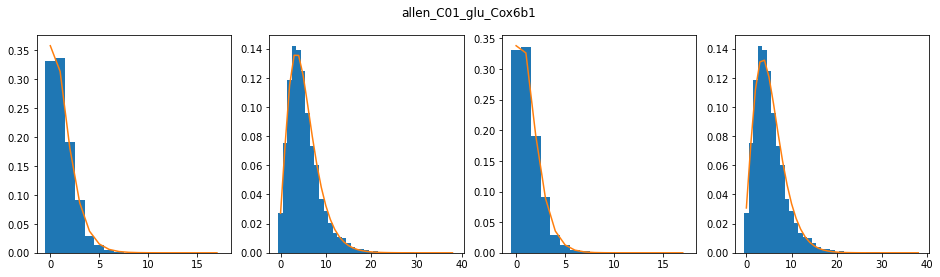

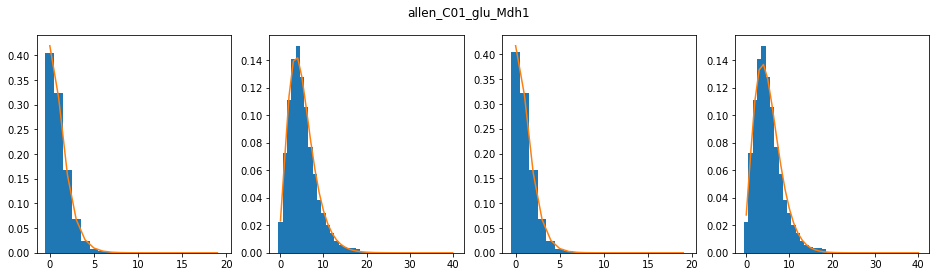

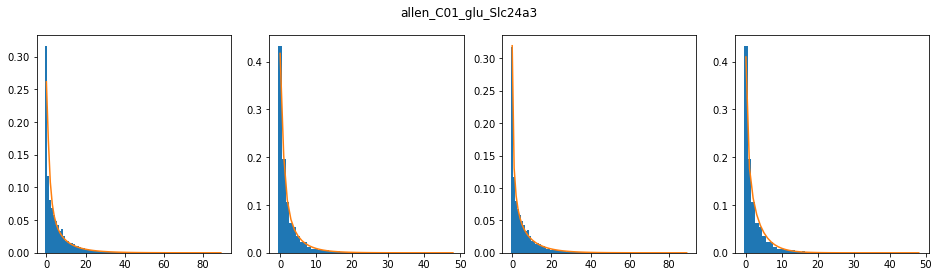

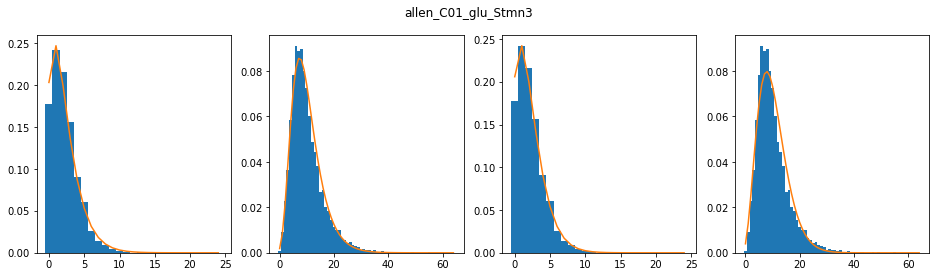

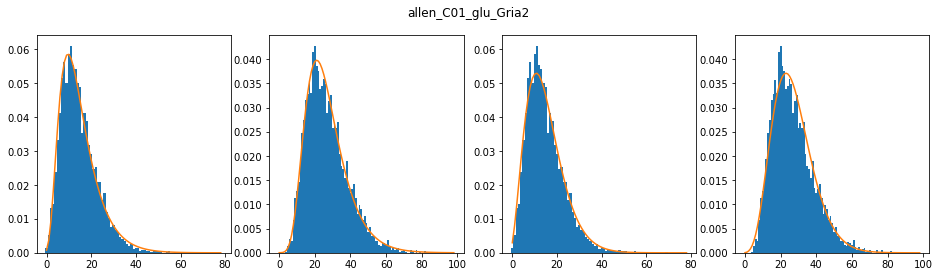

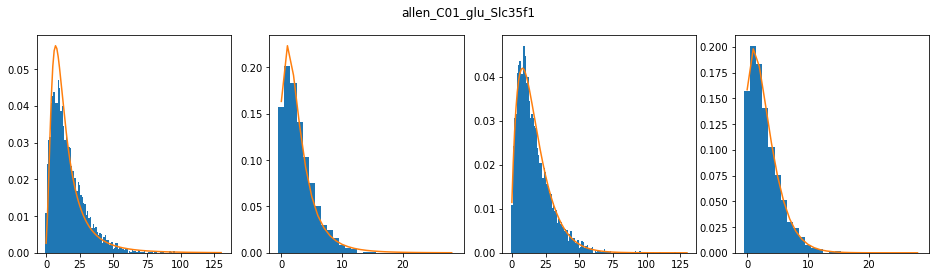

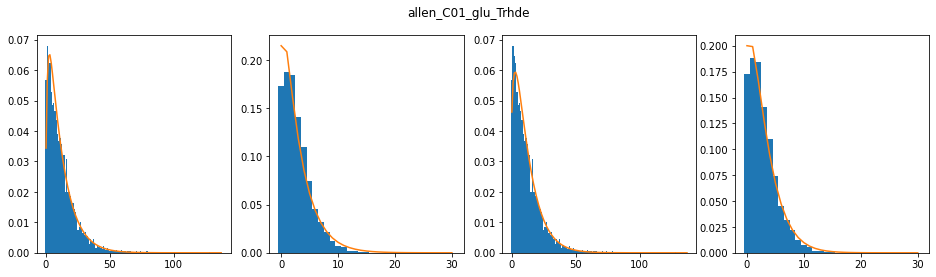

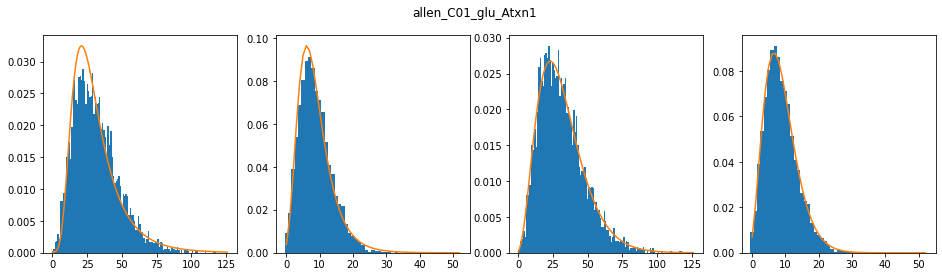

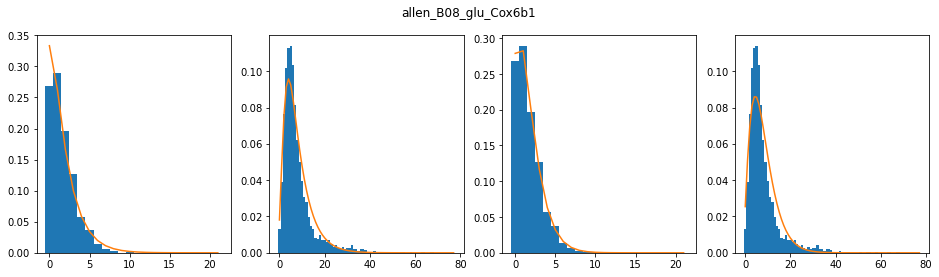

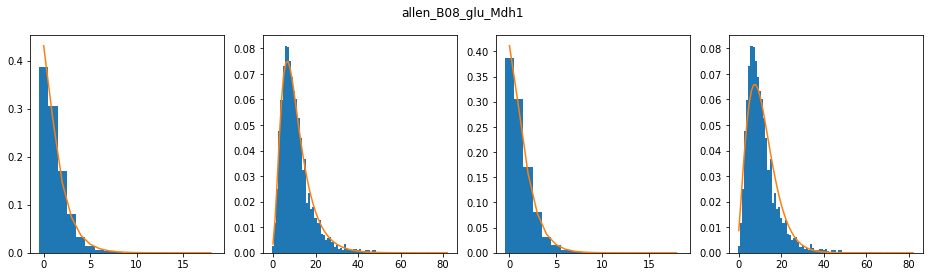

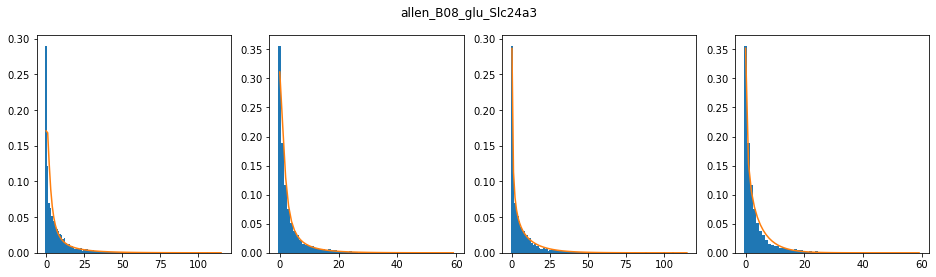

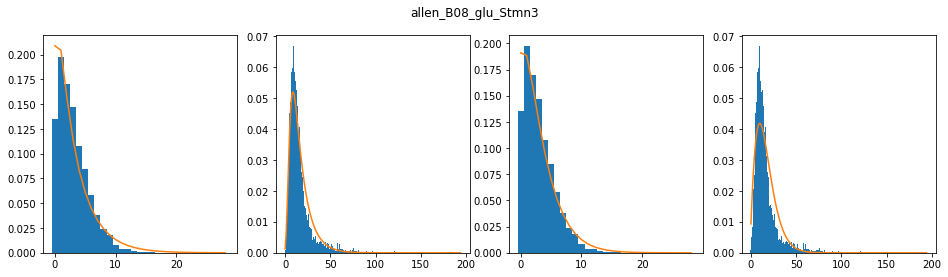

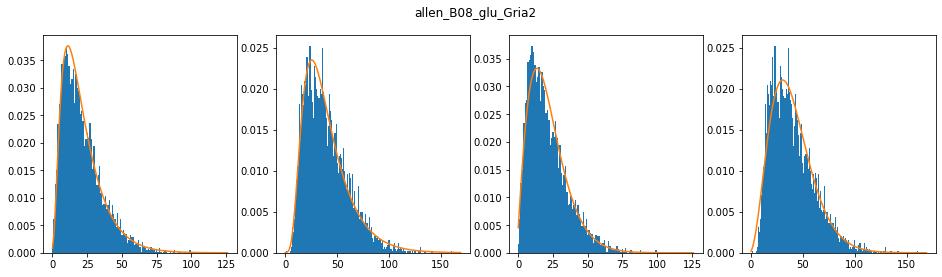

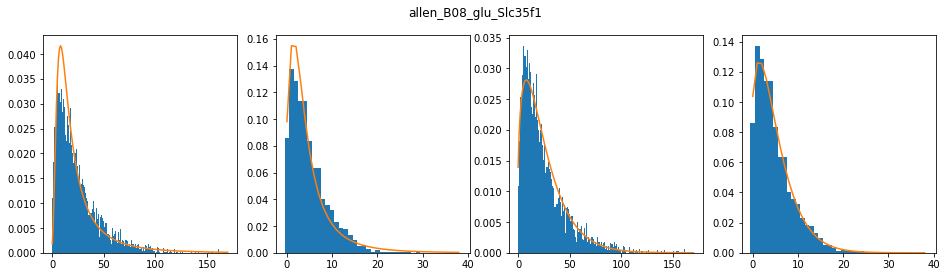

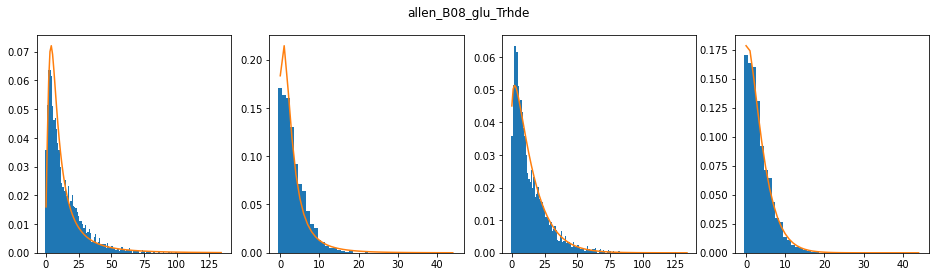

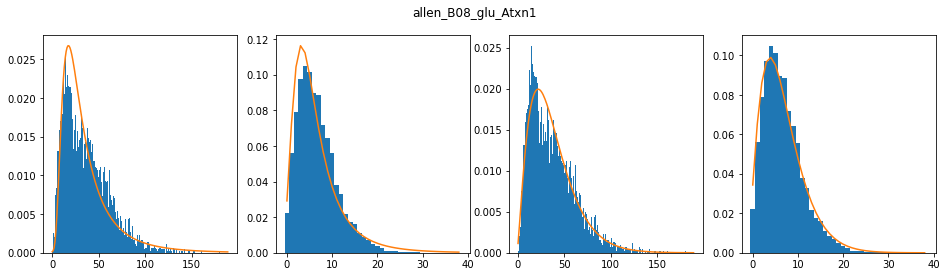

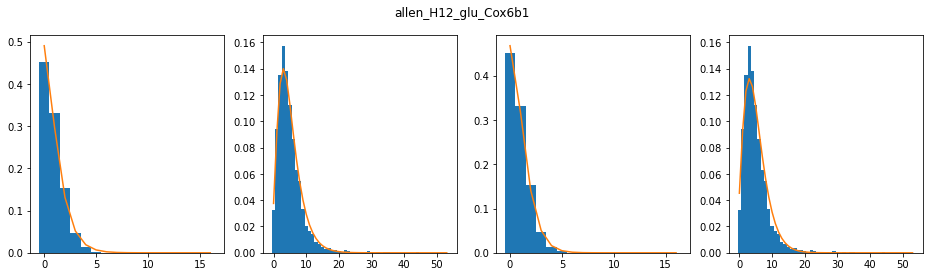

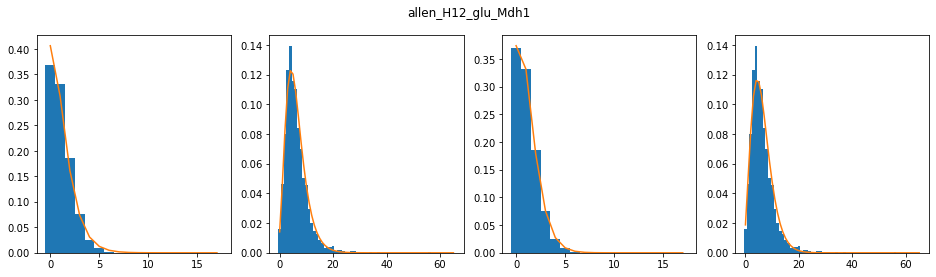

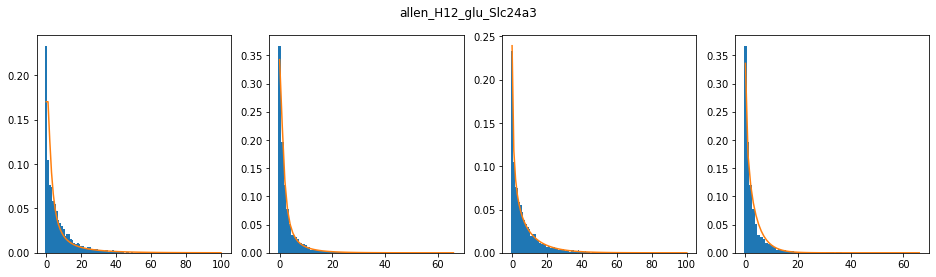

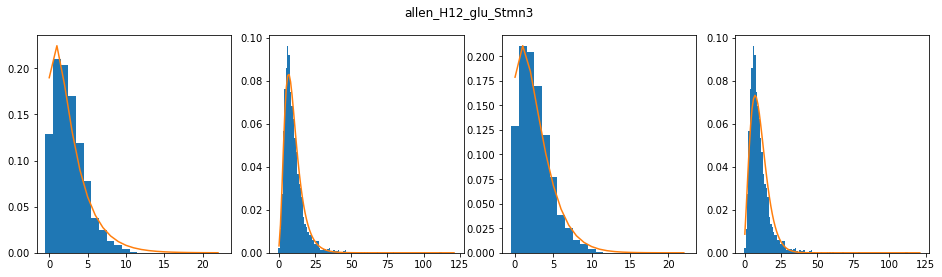

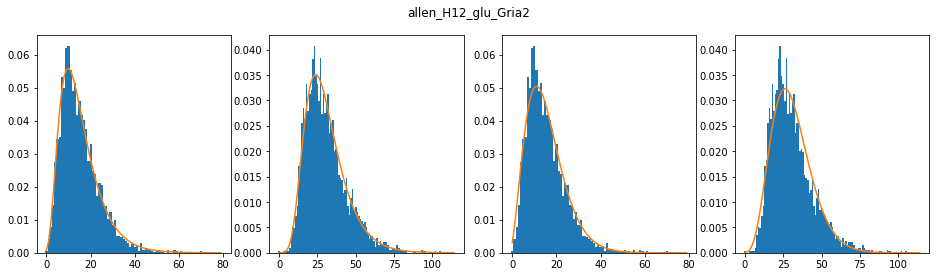

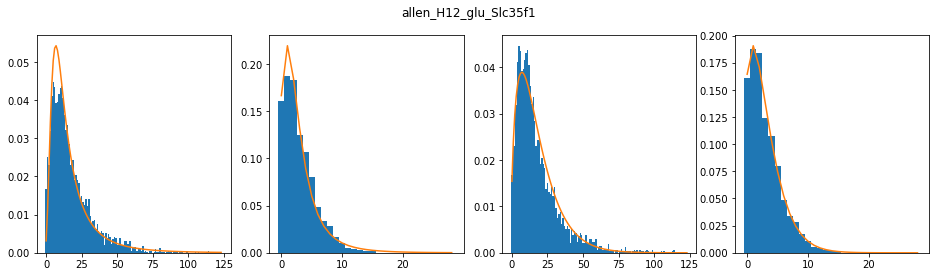

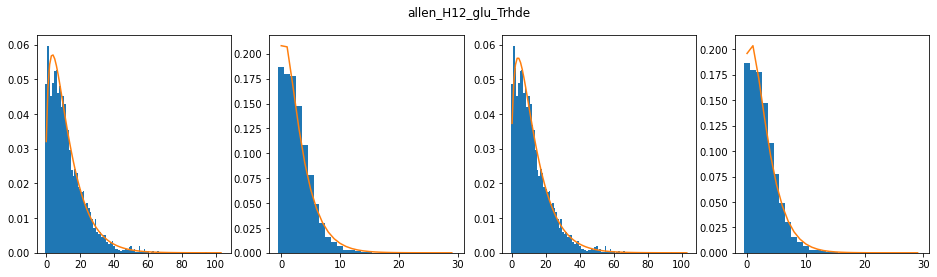

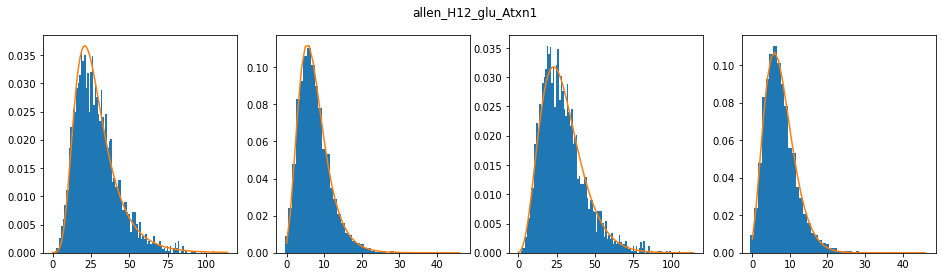

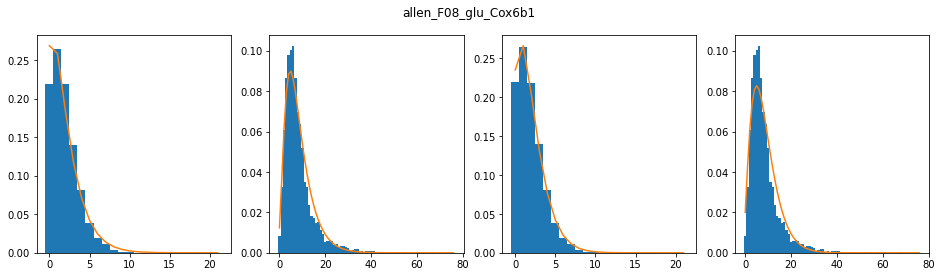

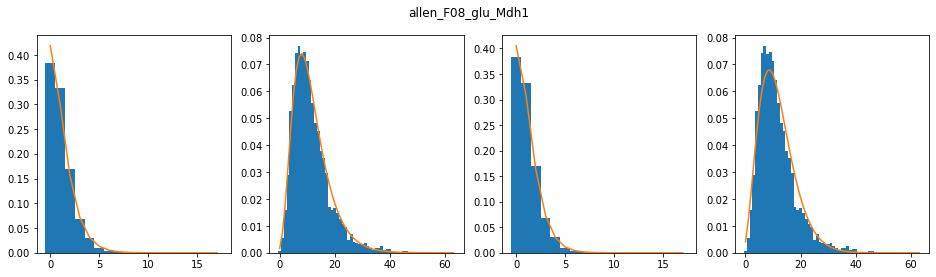

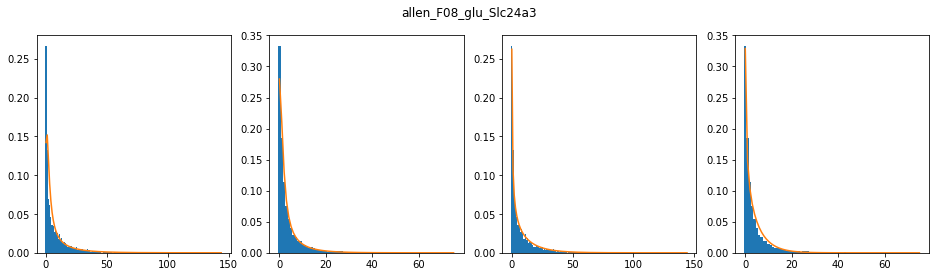

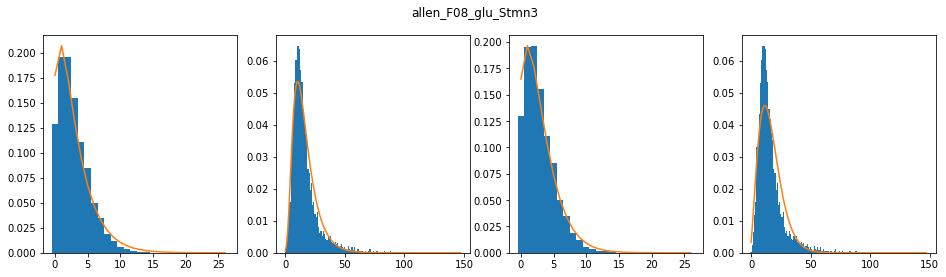

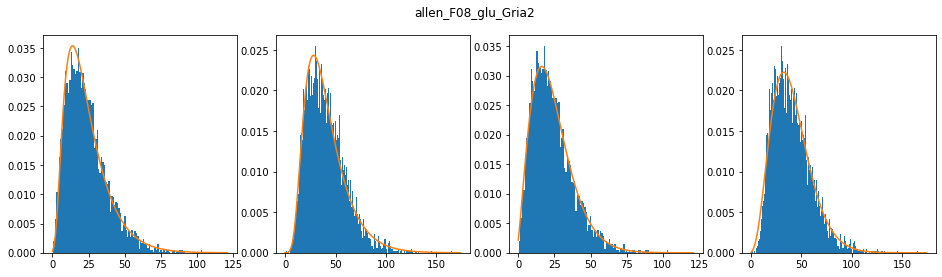

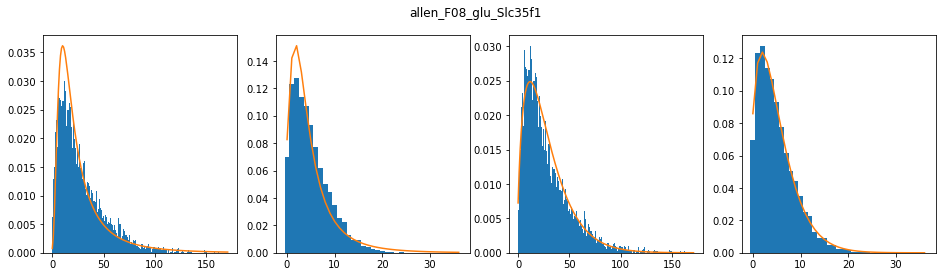

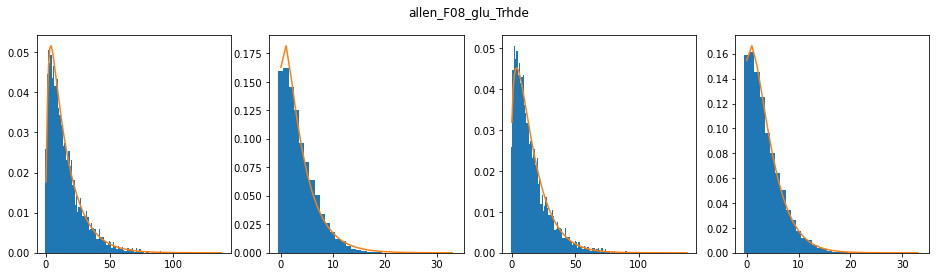

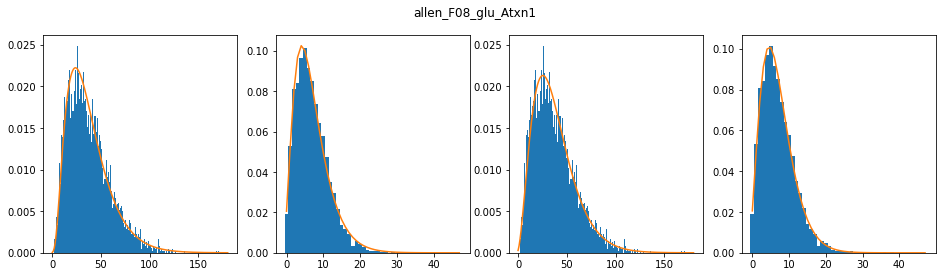

In [ ]:
Data = []
IDs = []
for sample in sample_lists:
    with lp.connect(sample+'.loom') as ds:
        S = ds.layers['spliced'][:]
        U = ds.layers['unspliced'][:]
        gene_names = ds.ra['gene_name']
        nCells = len(ds.ca['barcode'])
  
    for i,gene in enumerate(genes_list):
        fig, axs = plt.subplots(1,4,figsize=(16,4))
        gene_ID = sample+"_"+gene 
        IDs.append(gene_ID)
        i = np.where(gene_names==gene)[0][0]
        d_M = S[i].astype(int)
        d_N = U[i].astype(int)
        data = [d_N, d_M]
        plot_hist(data, gene_ID, "CIR", ax=axs[:2])
        plot_hist(data, gene_ID, "GOU", ax=axs[2:])
        fig.suptitle(gene_ID);
      

In [ ]:
def plot_posteriors_grid(gene_ID,axs):
    grid_folder="grid_results/"
    for i, model in enumerate(["CIR","GOU"]):
        model_ID = gene_ID+"_"+model
        logL=np.loadtxt(grid_folder+"logL_"+model_ID+".txt")

        c=np.max(logL)
        llh = np.power(10,logL-c)
        axs[i].imshow(np.transpose(llh), extent=(0,1,0,1), origin='lower');
        axs[i].set_title(model_ID)
    return

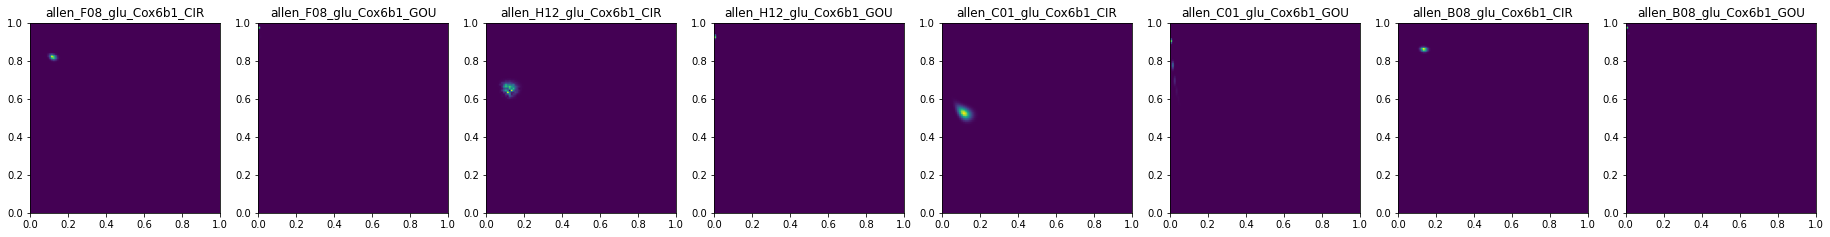

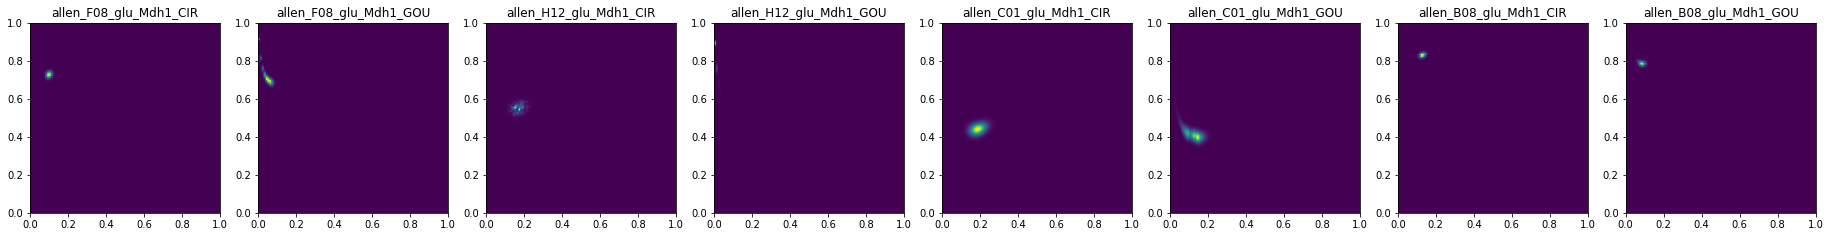

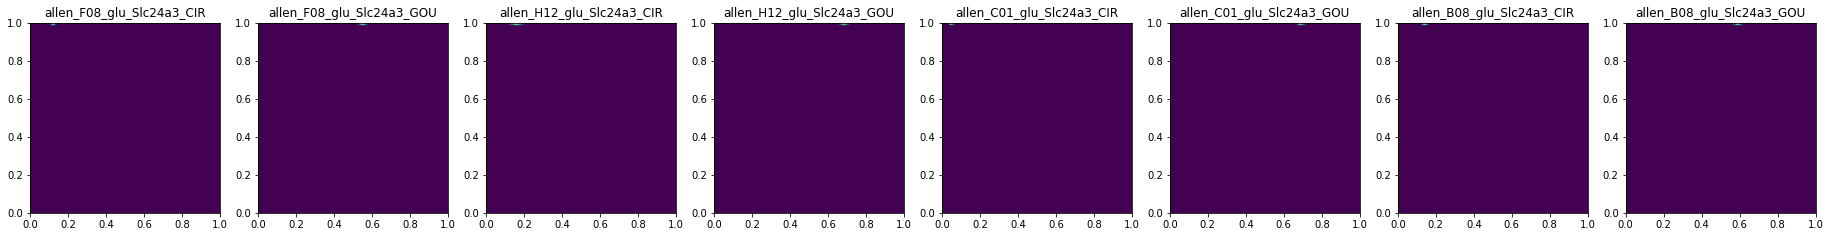

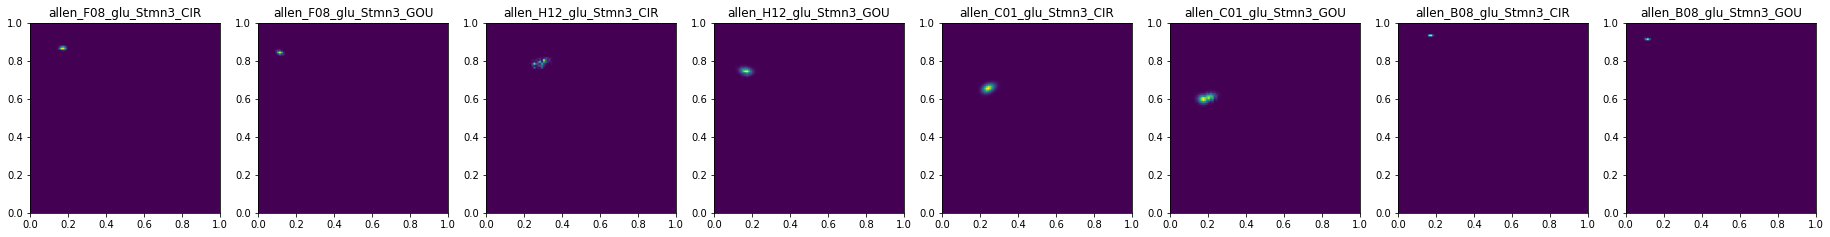

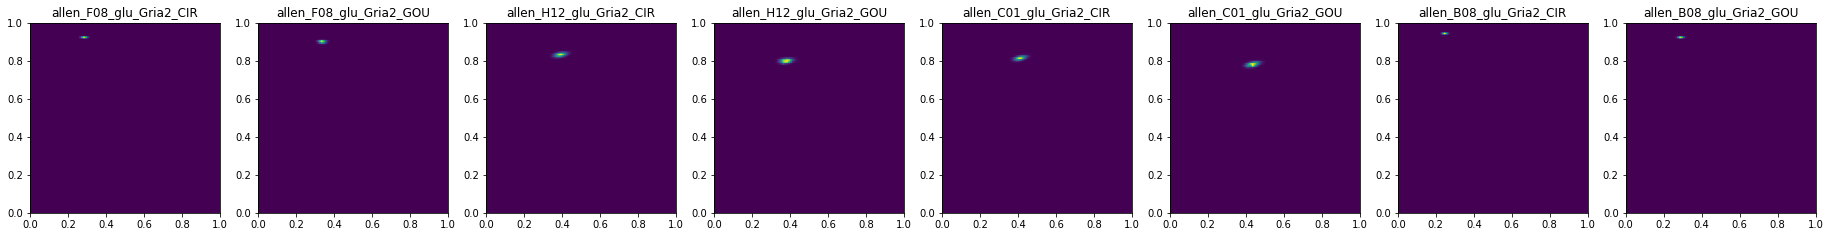

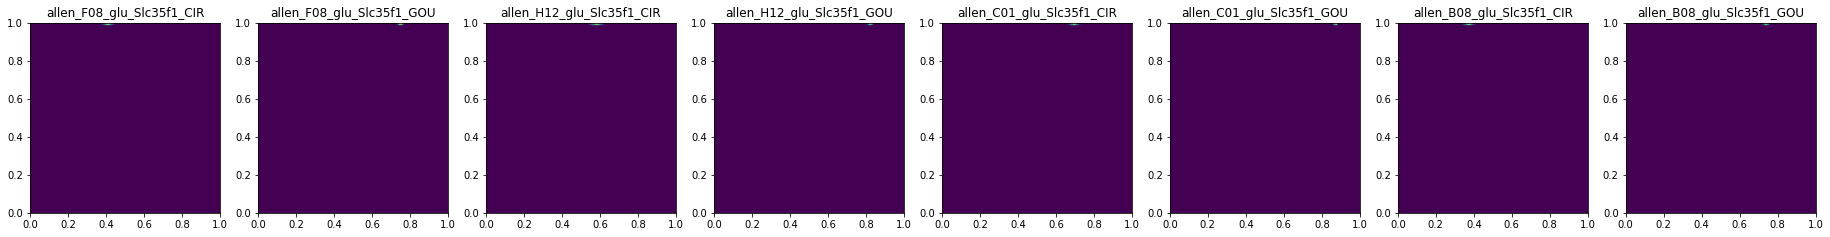

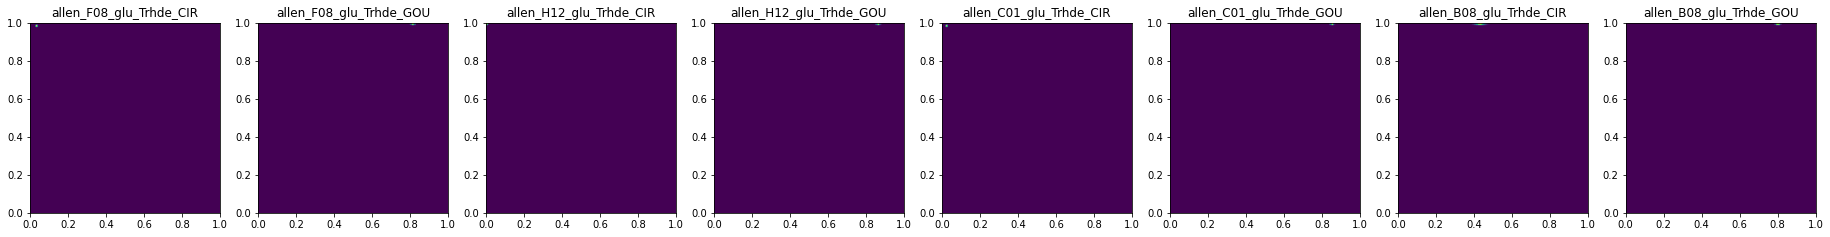

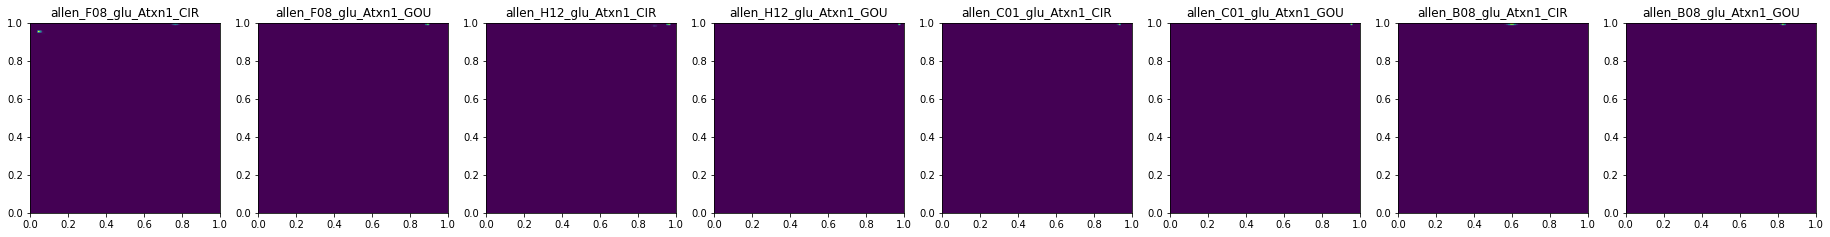

In [ ]:
Data = []
IDs = []

for i,gene in enumerate(genes_list):
    fig, axs = plt.subplots(1,8,figsize=(32,4))
    for j,sample in enumerate(sample_lists):
      gene_ID = sample+"_"+gene
      IDs.append(gene_ID)
      i = np.where(gene_names==gene)[0][0]
      d_M = S[i].astype(int)
      d_N = U[i].astype(int)
      data = [d_N, d_M]
      K_avg = 1
      beta = K_avg/d_N.mean()
      gamma = K_avg/d_M.mean()
      plot_posteriors_grid(gene_ID,  axs[(2*j):(2*j+2)])

### SMC

In [ ]:
sample_lists = ["allen_H12_glu","allen_F08_glu"]
genes_list = ['Cox6b1', 'Mdh1', 'Slc24a3', 'Stmn3', 'Gria2', 'Slc35f1', 'Trhde', 'Atxn1']
tstart = ti.time()
Data = []
for sample in sample_lists:
    with lp.connect("loom/"+sample+'.loom') as ds:
        S = ds.layers['spliced'][:]
        U = ds.layers['unspliced'][:]
        gene_names = ds.ra['gene_name']
        nCells = len(ds.ca['barcode'])
  
    for i,gene in enumerate(genes_list):
      gene_ID = sample+"_"+gene 
      i = np.where(gene_names==gene)[0][0]
      d_M = S[i].astype(int)
      d_N = U[i].astype(int)
      data = [d_N, d_M]
      Data.append((data,gene_ID))
      
n_threads = min(40,len(Data))
with Pool(n_threads) as pool:      
    log10_BF, IDs  = zip(*pool.starmap(get_log_bayes_factor_data, Data))


data = pd.DataFrame({'IDs': IDs, 'log10_BF': log10_BF})
data.to_csv("BF_smc_2.csv")

print("time:", - tstart + ti.time())
print('log10_BF:',log10_BF)

In [ ]:
def plot_posteriors_smc(gene_ID, params, axs=None, loc=False):

    with open("loom/smc_results/smc_"+gene_ID+"_trace.pickle", 'rb') as f:
        data = pickle.load(f)

    beta, gamma, K_avg = params
    if axs is None:
        fig, axs = plt.subplots(1,2,figsize=(8,4))
    for i, model in enumerate(["CIR","GOU"]):
        ax = axs[i]
        string_ID = gene_ID + "_" + model
        ax.set_title(string_ID)

        trace = data[model]
        x_stats, y_stats = trace['x'], trace['y']
        a_stats, kappa_stats, theta_stats = convert_xy_to_params(x_stats, y_stats, beta, gamma, K_avg)

        # KDEs
        KDE_xy, x_arg, y_arg = get_2D_KDE(x_stats, y_stats, 0, 1, 0, 1)       
        KDE_x = np.sum(KDE_xy, axis=1)
        KDE_x = KDE_x/np.trapz(KDE_x, x=x_arg)
        KDE_y = np.sum(KDE_xy, axis=0)
        KDE_y = KDE_y/np.trapz(KDE_y, x=y_arg)
        
        # Summary statistics
        x_avg, y_avg = np.mean(x_stats), np.mean(y_stats)    # posterior means
        i, j = get_2D_max(KDE_xy)
        x_map, y_map = x_arg[i], y_arg[j]

        s= mpl.rcParams['lines.markersize']**2
        newsize=0.5*s
        ax.scatter(x_map, y_map, color='blue', label='MAP', s=newsize, edgecolor='white')
        ax.scatter(x_avg, y_avg, color='red', label='avg', s=newsize, edgecolor='white')
        # ax.scatter(x_true, y_true, color='black', label='true', s=newsize, edgecolor='white')
        ax.imshow(np.transpose(KDE_xy), origin='lower', extent=[0, 1, 0, 1])

        if loc==True:
            plt.legend(fontsize=18, framealpha=1)
        #plt.savefig('results/post_2D_xy_'+string_ID+'.pdf', bbox_inches='tight')
        #plt.savefig('results/post_2D_xy_'+string_ID+'.png', bbox_inches='tight')
    return

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


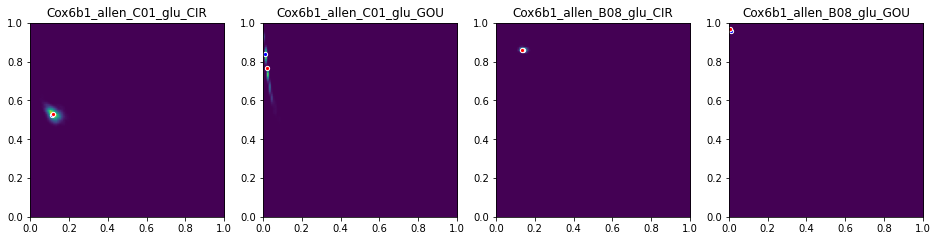

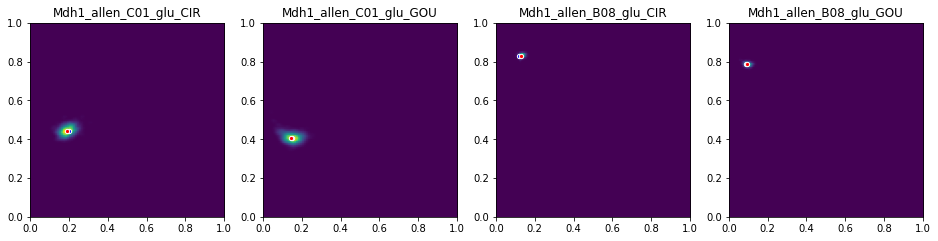

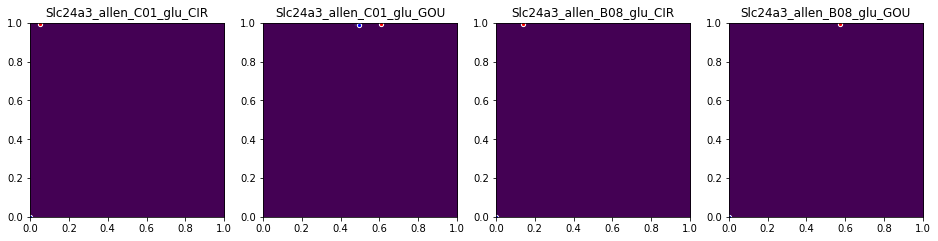

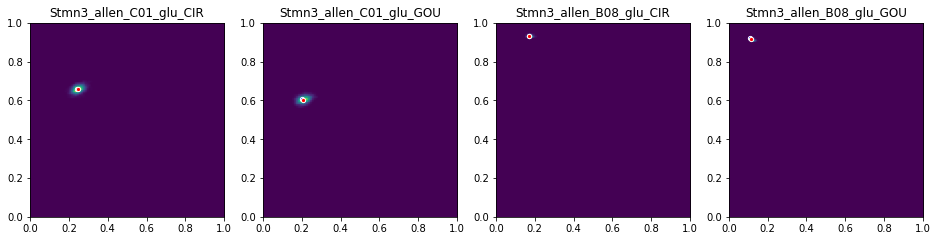

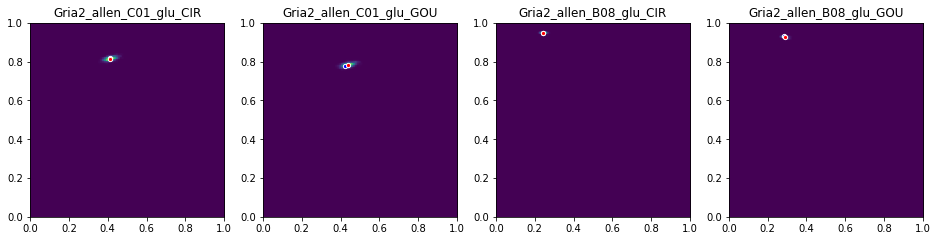

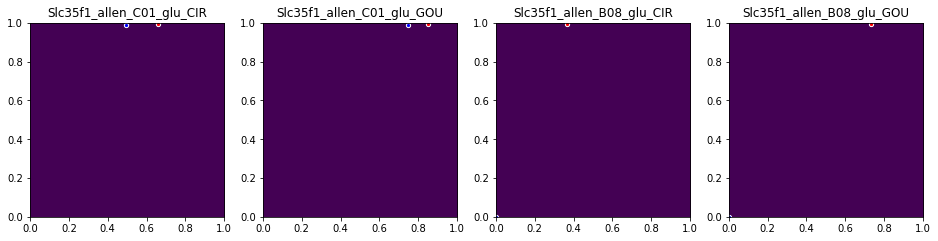

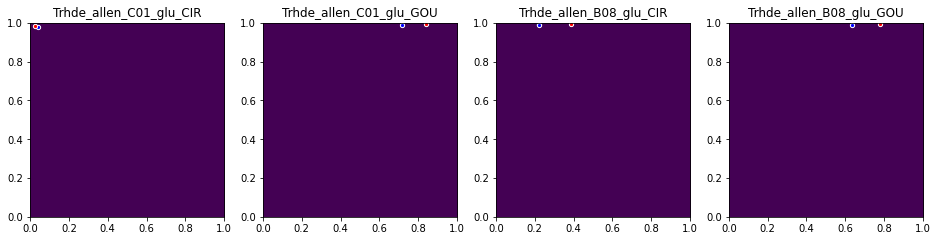

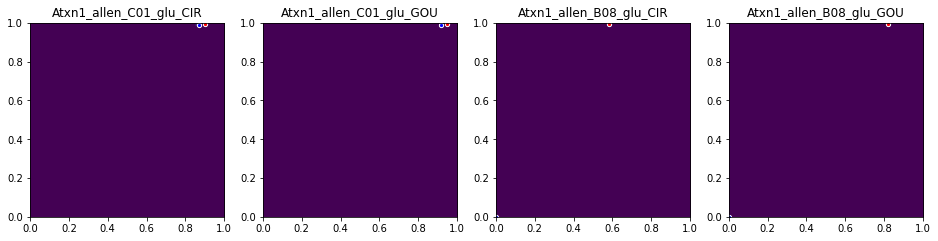

In [ ]:
sample_lists = ["allen_C01_glu","allen_B08_glu"]
genes_list = ['Cox6b1', 'Mdh1', 'Slc24a3', 'Stmn3', 'Gria2', 'Slc35f1', 'Trhde', 'Atxn1']
Data = []
IDs = []

for i,gene in enumerate(genes_list):
    fig, axs = plt.subplots(1,4,figsize=(16,4))
    for j,sample in enumerate(sample_lists):
      gene_ID = gene+"_"+sample
      IDs.append(gene_ID)
      i = np.where(gene_names==gene)[0][0]
      d_M = S[i].astype(int)
      d_N = U[i].astype(int)
      data = [d_N, d_M]
      K_avg = 1
      beta = K_avg/d_N.mean()
      gamma = K_avg/d_M.mean()
      plot_posteriors_smc(gene_ID, [beta, gamma, K_avg], axs[(2*j):(2*j+2)])